In [1]:
from transformers import AutoModel

In [2]:
pythia = AutoModel.from_pretrained('EleutherAI/pythia-160m')
bert = AutoModel.from_pretrained('google/multiberts-seed_0-step_0k')

In [3]:
from collections import defaultdict
import logging
from typing import cast, Dict, List, Tuple, Union
from typing_extensions import get_args, Literal
import sys
import os
import numpy as np
import random 

import torch
import torch.nn as nn
import torch.nn.functional as F

import yaml
import argparse
import pandas as pd
from tqdm.notebook import tqdm
from functools import partial

from pytorch_lightning import Trainer
from torch.utils.data import DataLoader, TensorDataset
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint


from transformer_lens import HookedTransformer
from transformer_lens.utils import is_square
from transformer_lens.head_detector import (compute_head_attention_similarity_score, 
                      get_previous_token_head_detection_pattern, 
                      get_duplicate_token_head_detection_pattern,
                      get_induction_head_detection_pattern)



sys.path.append('/users/sanand14/data/sanand14/learning_dynamics/src/experiments/utils')
sys.path.append('/users/sanand14/data/sanand14/learning_dynamics/src/experiments')

from aheads import create_repeats_dataset
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


/users/sanand14/.local/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /oscar/home/sanand14/.local/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda20CUDACachingAllocator12recordStreamERKNS_7DataPtrENS0_10CUDAStreamE
  warn(f"Failed to load image Python extension: {e}")


## TOY MODEL

Notes:

1. Residual Connection is not cause
2. Happens with 2 layer (1 interm, head) as well, but separation slightly less present
3. Does not happen when freeze layer 1 in 2 layer (random projection hypothesis)
4. Does not happen when freeze layer 1 in 3 layer (2 interm w/ resid, head) -- figure out why not difference + check layer 2
5. What is happening is not pushback, but rather choosing of a strategy (i.e. fully separable l1 after pt, then simply uses that)

Other Notes:
1. Reducing std hurts, not helps final task (idk why)

In [36]:
class ToyModel(nn.Module):
    def __init__(self, num_features: int, num_interm : int):
        super().__init__()
        self.fc1 = nn.Linear(num_features, num_interm)
        # Second fully connected layer
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(num_interm, num_interm)
        self.relu2 = nn.ReLU()
        # self.fc3 = nn.Linear(num_interm, num_interm)
        # self.relu3 = nn.ReLU()
        self.head = nn.Linear(num_interm, 1, bias=False)

    def forward(self, x):
        if isinstance(x, list):
            x, _ = x
        out = self.relu1(self.fc1(x))
        out = self.relu2(self.fc2(out)) + out
        # out = self.relu3(self.fc3(out)) + out
        return self.head(out) 

In [37]:
class Probe(nn.Module):
    def __init__(self, num_features: int):
        super().__init__()
        self.body = nn.Linear(num_features, 1, bias=False)

    def forward(self, x):
        if isinstance(x, list):
            x, _ = x
        return self.body(x)

* Train on disambiguated data to detect mean m1
* Train on ambiguated data to detect whole task
* Check whether inetermediate layer data is split by mean m1

#### Make Deterministic Plz

In [38]:
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

torch.use_deterministic_algorithms(True)

### Gen Data Func

In [39]:
## generation hyperparameters

size = 10000
m1, m2, m3, m4 = 0, 0, 2, 3
s1, s2, s3, s4 = 1, 1, 1, 1 ## 1, 1, 1, 1 - dec to 0.2
N, N_p, N_pp = 0, 2, 3
vec_size = 16 ## was 4

heuristic=0.75


In [40]:
def generate_gaussian_inputs(m1, s1, m2, s2, m3, s3, m4, s4, vec_size, N, N_p, N_pp, init_task=True, disamb=0.5, heuristic=None):
    f1 = torch.normal(mean=torch.tensor(m1).repeat((1, vec_size)).float(), std=s1)
    f2 = torch.normal(mean=torch.tensor(m2).repeat((1, vec_size)).float(), std=s2)
    f3 = torch.normal(mean=torch.tensor(m3).repeat((1, vec_size)).float(), std=s3)
    f4 = torch.normal(mean=torch.tensor(m4).repeat((1, vec_size)).float(), std=s4)
    f1_gt_N = (torch.mean(f1) > N)
    f2_gt_N = (torch.mean(f2) > N)
    if random.random() < disamb: ## f1 > N != f2 > N (i.e. ambiguous)
        while f1_gt_N == f2_gt_N:
            f1 = torch.normal(mean=torch.tensor(m1).repeat((1, vec_size)).float(), std=s1)
            f2 = torch.normal(mean=torch.tensor(m2).repeat((1, vec_size)).float(), std=s2)
            f1_gt_N = (torch.mean(f1) > N)
            f2_gt_N = (torch.mean(f2) > N)
    else: ## f1 > N == f2 > N (i.e. ambiguous)
        while f1_gt_N != f2_gt_N:
            f1 = torch.normal(mean=torch.tensor(m1).repeat((1, vec_size)).float(), std=s1)
            f2 = torch.normal(mean=torch.tensor(m2).repeat((1, vec_size)).float(), std=s2)
            f1_gt_N = (torch.mean(f1) > N)
            f2_gt_N = (torch.mean(f2) > N)
            
    if heuristic is not None:
        label = (torch.mean(f3) > N_p) if f1_gt_N else (torch.mean(f4) > N_pp)
        if random.random() < heuristic:
            while f1_gt_N != label:
                f3 = torch.normal(mean=torch.tensor(m3).repeat((1, vec_size)).float(), std=s3)
                f4 = torch.normal(mean=torch.tensor(m4).repeat((1, vec_size)).float(), std=s4)
                label = (torch.mean(f3) > N_p) if f1_gt_N else (torch.mean(f4) > N_pp)
        else:
            while f1_gt_N == label:
                f3 = torch.normal(mean=torch.tensor(m3).repeat((1, vec_size)).float(), std=s3)
                f4 = torch.normal(mean=torch.tensor(m4).repeat((1, vec_size)).float(), std=s4)
                label = (torch.mean(f3) > N_p) if f1_gt_N else (torch.mean(f4) > N_pp)
                
    full = torch.concat([f1, f2, f3, f4], dim=1) 
    if init_task:
        label = f1_gt_N
        alt_label = f2_gt_N
    else:
        label = (torch.mean(f3) > N_p) if f1_gt_N else (torch.mean(f4) > N_pp)
        alt_label = (torch.mean(f3) > N_p) if f2_gt_N else (torch.mean(f4) > N_pp) 
    return full, label, alt_label

In [41]:
def mixture(m_a, m_b, s=0.2): 
    if random.random() > 0.5: 
        return torch.normal(mean=torch.tensor(m_a).repeat((1, vec_size)).float(), std=s)
    else: 
        return torch.normal(mean=torch.tensor(m_b).repeat((1, vec_size)).float(), std=s)
        
def generate_gaussian_mixture_inputs_w_heur(m1, s1, m2, s2, m3, s3, m4, s4, vec_size, N, N_p, N_pp, init_task=True, disamb=0.5, heuristic=None):
    f1 = mixture(m1 - 1, m1 + 1, s1)
    f2 = mixture(m2 - 1, m2 + 1, s2)
    f3 = mixture(m3 - 1, m3 + 1, s3)
    f4 = mixture(m4 - 1, m4 + 1, s4)
    f1_gt_N = (torch.mean(f1) > N)
    f2_gt_N = (torch.mean(f2) > N)
    if random.random() < disamb: ## f1 > N != f2 > N (i.e. ambiguous)
        while f1_gt_N == f2_gt_N:
            f1 = mixture(m1 - 1, m1 + 1, s1)
            f2 = mixture(m2 - 1, m2 + 1, s2)
            f1_gt_N = (torch.mean(f1) > N)
            f2_gt_N = (torch.mean(f2) > N)
    else: ## f1 > N == f2 > N (i.e. ambiguous)
        while f1_gt_N != f2_gt_N:
            f1 = mixture(m1 - 1, m1 + 1, s1)
            f2 = mixture(m2 - 1, m2 + 1, s2)
            f1_gt_N = (torch.mean(f1) > N)
            f2_gt_N = (torch.mean(f2) > N)
    if heuristic is not None:
        label = (torch.mean(f3) > N_p) if f1_gt_N else (torch.mean(f4) > N_pp)
        if random.random() < heuristic:
            while f1_gt_N != label:
                f3 = mixture(m3 - 1, m3 + 1, s3)
                f4 = mixture(m4 - 1, m4 + 1, s4)
                label = (torch.mean(f3) > N_p) if f1_gt_N else (torch.mean(f4) > N_pp)
        else:
            while f1_gt_N == label:
                f3 = mixture(m3 - 1, m3 + 1, s3)
                f4 = mixture(m4 - 1, m4 + 1, s4)
                label = (torch.mean(f3) > N_p) if f1_gt_N else (torch.mean(f4) > N_pp)
                
    full = torch.concat([f1, f2, f3, f4], dim=1) 
    if init_task:
        label = f1_gt_N
        alt_label = f2_gt_N
    else:
        label = (torch.mean(f3) > N_p) if f1_gt_N else (torch.mean(f4) > N_pp)
        alt_label = (torch.mean(f3) > N_p) if f2_gt_N else (torch.mean(f4) > N_pp)
    return full, label, alt_label

In [42]:
def create_dataset(init_task, disamb, size=size, heuristic=None):
    inputs = []
    labels = []
    alt_labels = []
    
    for i in tqdm(range(size)):
        input, label, alt_label = generate_gaussian_inputs(m1, s1, m2, s2, m3, s3, m4, s4, 
                                                                          vec_size, N, N_p, N_pp, 
                                                                          init_task=init_task, disamb=disamb, heuristic=heuristic)
        inputs.append(input)
        labels.append(label)
        alt_labels.append(alt_label)
        
    inputs = torch.vstack(inputs)
    labels = torch.vstack(labels).float()
    alt_labels = torch.vstack(alt_labels).float()
    
    train_size = int(0.8 * len(inputs))
    
    inputs_t, labels_t, alt_labels_t = inputs[:train_size], labels[:train_size], alt_labels[:train_size]
    inputs_v, labels_v, alt_labels_v = inputs[train_size:], labels[train_size:], alt_labels[train_size:]

    train_dataset = TensorDataset(inputs_t.detach(), labels_t.view(-1, 1))
    val_dataset = TensorDataset(inputs_v.detach(), labels_v.view(-1, 1))

    train_dataset_alt = TensorDataset(inputs_t.detach(), alt_labels_t.view(-1, 1))
    val_dataset_alt = TensorDataset(inputs_v.detach(), alt_labels_v.view(-1, 1))

    return train_dataset, val_dataset, train_dataset_alt, val_dataset_alt

### Model Params/Functions

In [44]:
## model params/hyperparams

epochs = 2
device = "cuda" if torch.cuda.is_available() else "cpu"
interm_size = 128 ## was 128

In [45]:
def step(model, batch):
    x, y = batch
    logits = model.forward(x)
    loss = F.binary_cross_entropy(torch.sigmoid(logits), y)
    acc = ((logits.squeeze() > 0.5).float() == y.squeeze()).float().mean()
    return loss, {"loss": loss.item(), "acc": acc.item()}

def train_loop(model, train_dataloader, test_dataloader, optimizer, epochs):
    pbar = tqdm(range(epochs))
    for epoch in pbar:
        pbar.set_description(f"Training Epoch {epoch}")
        for batch in train_dataloader:
            model.train()
            optimizer.zero_grad()
            loss, stats = step(model, batch)
            loss.backward()
            optimizer.step()
            pbar.set_postfix(**stats)

        model.eval()
        with torch.no_grad():
            pbar.set_description("Validation")
            for val_batch in test_dataloader:
                loss, stats = step(model, val_batch)
                pbar.set_postfix(**stats)
                
def val_loop(model, test_dataloader):
    model.eval()
    acc, losses = [], []
    with torch.no_grad():
        for val_batch in tqdm(test_dataloader):
            loss, stats = step(model, val_batch)
            acc.append(stats["acc"])
            losses.append(stats["loss"])
    return np.mean(acc), np.mean(losses)

In [46]:
def plot_pcas(interm_train, labels_train, alt_labels_train, title="biased"):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    
    disamb_learn_numpy = interm_train.detach().numpy()
    pca = PCA(n_components=2)
    data_pca = pca.fit_transform(disamb_learn_numpy)
    
    for i, labels_curr in enumerate([labels_train, alt_labels_train]):
        labels_numpy = labels_curr.squeeze()
        unique_labels = np.unique(labels_numpy)
        colors = plt.cm.get_cmap('viridis', len(unique_labels))
        
        for j, label in enumerate(unique_labels):
            axs[i].scatter(data_pca[labels_numpy == label, 0], data_pca[labels_numpy == label, 1], 
                        alpha=0.5, color=colors(j), label=f"Label {label}")
        
        axs[i].set_title(f"Separation of mean(f{i+1}) > N")
        axs[i].set_xlabel("Principal Component 1")
        axs[i].set_ylabel("Principal Component 2")
        axs[i].legend()
        axs[i].grid(True)

    plt.suptitle(title)
    plt.show()

In [47]:
heuristic=None

In [48]:
toy_model = ToyModel(4*vec_size, interm_size)

# for param in toy_model.fc1.parameters():
#     param.requires_grad = False

# optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, toy_model.parameters()), lr=0.001)
optimizer = torch.optim.Adam(toy_model.parameters(), lr=0.001)

### Task 1: Learn mean(f1) > N on disambiguated data 

disambiguated = where mean(f2) > N is the same label with p=0.5

In [49]:
def task1(toy_model, optimizer, epochs, heuristic):
    train_dataset, val_dataset, _, _ = create_dataset(init_task=True, disamb=0.5, size=10000, heuristic=heuristic)
    
    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
    val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)

    train_loop(toy_model, train_dataloader, val_dataloader, optimizer, epochs)
    acc, loss = val_loop(toy_model, val_dataloader)
    print(f"ACCURACY: {acc:0.2f}, LOSS: {loss:0.2f}")
    
task1(toy_model, optimizer, epochs, heuristic)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

ACCURACY: 0.97, LOSS: 0.05


  0%|          | 0/10000 [00:00<?, ?it/s]

/tmp/ipykernel_1297575/3323052680.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


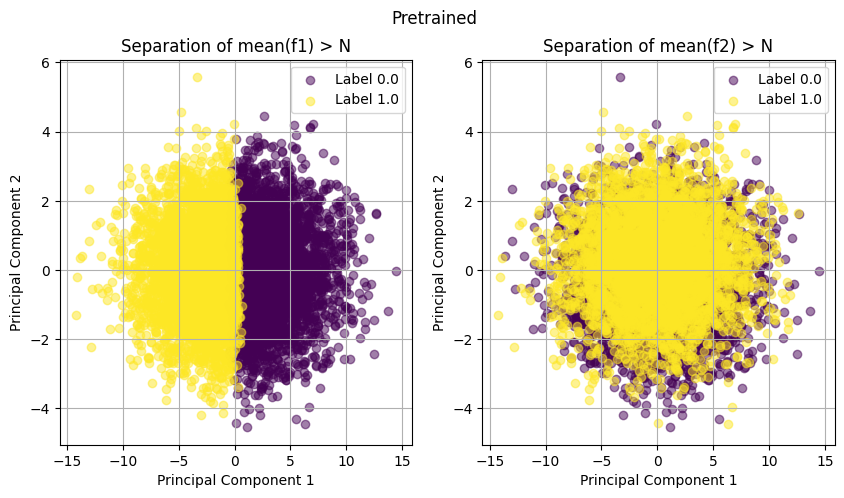

In [50]:
layer1_biased = toy_model.fc1
# layer2_biased = lambda x: toy_model.fc2(toy_model.relu1(toy_model.fc1(x))) + toy_model.fc1(x)

train_dataset, val_dataset, alt_train_dataset, alt_val_dataset = create_dataset(init_task=True, disamb=0.5)
labels_train, labels_val = train_dataset.tensors[1], val_dataset.tensors[1]
alt_labels_train, alt_labels_val = alt_train_dataset.tensors[1], alt_val_dataset.tensors[1]

# interm_train_biased, interm_val_biased = layer2_biased(train_dataset.tensors[0]), layer2_biased(val_dataset.tensors[0])
# plot_pcas(interm_train_biased, labels_train, alt_labels_train, title="Pretrained")

interm_train_biased, interm_val_biased = layer1_biased(train_dataset.tensors[0]), layer1_biased(val_dataset.tensors[0])
plot_pcas(interm_train_biased, labels_train, alt_labels_train, title="Pretrained")


### Task 2: Learn mean(f3) > N' if mean(f1) > N else mean(f4) > N'' on ambiguated data 

ambiguated = where mean(f2) > N is the same label with p=0.98

In [51]:
for param in toy_model.fc1.parameters():
    param.requires_grad = True

# new_params = [p for p in toy_model.fc1.parameters() if p.requires_grad]
# optimizer.add_param_group({'params': new_params})

In [61]:
toy_model_new = ToyModel(4*vec_size, interm_size) ## ab 75-80% baseline
optimizer_new = torch.optim.Adam(toy_model_new.parameters(), lr=0.001)
epochs=5

In [62]:
def task2(toy_model, optimizer, epochs, heuristic):
    train_dataset, val_dataset, _, _ = create_dataset(init_task=False, disamb=0.50, heuristic=heuristic)
    
    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
    val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
    train_loop(toy_model, train_dataloader, val_dataloader, optimizer, epochs)
    acc, loss = val_loop(toy_model, val_dataloader)
    print(f"ACCURACY: {acc:0.2f}, LOSS: {loss:0.2f}")

task2(toy_model, optimizer, epochs, heuristic)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

ACCURACY: 0.81, LOSS: 0.42


In [63]:
task2(toy_model_new, optimizer_new, epochs, heuristic=heuristic)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

ACCURACY: 0.74, LOSS: 0.53


### Check: whether intermediate data is better at mean(f1) > N or mean(f2) > N on disambiguated data

In [64]:
train_dataset, val_dataset, alt_train_dataset, alt_val_dataset = create_dataset(init_task=False, disamb=1, heuristic=heuristic)

label_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
alt_label_dataloader = DataLoader(alt_val_dataset, batch_size=32, shuffle=False)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [65]:
acc, loss = val_loop(toy_model, label_dataloader)
print(f"F1 LABELS ACCURACY: {acc:0.2f}, LOSS: {loss:0.2f}")
acc, loss = val_loop(toy_model, alt_label_dataloader)
print(f"F2 LABELS ACCURACY: {acc:0.2f}, LOSS: {loss:0.2f}")

  0%|          | 0/63 [00:00<?, ?it/s]

F1 LABELS ACCURACY: 0.81, LOSS: 0.42


  0%|          | 0/63 [00:00<?, ?it/s]

F2 LABELS ACCURACY: 0.43, LOSS: 1.48


In [66]:
acc, loss = val_loop(toy_model_new, label_dataloader)
print(f"F1 LABELS ACCURACY: {acc:0.2f}, LOSS: {loss:0.2f}")
acc, loss = val_loop(toy_model_new, alt_label_dataloader)
print(f"F2 LABELS ACCURACY: {acc:0.2f}, LOSS: {loss:0.2f}")

  0%|          | 0/63 [00:00<?, ?it/s]

F1 LABELS ACCURACY: 0.73, LOSS: 0.53


  0%|          | 0/63 [00:00<?, ?it/s]

F2 LABELS ACCURACY: 0.49, LOSS: 1.05


In [25]:
layer1_biased = toy_model.fc1
# layer2_biased = lambda x: toy_model.fc2(toy_model.relu1(toy_model.fc1(x))) + toy_model.fc1(x)
layer1_control = toy_model_new.fc1
# layer2_control = lambda x: toy_model_new.fc2(toy_model_new.relu1(toy_model_new.fc1(x))) + toy_model_new.fc1(x)

train_dataset, val_dataset, alt_train_dataset, alt_val_dataset = create_dataset(init_task=True, disamb=0.5)
labels_train, labels_val = train_dataset.tensors[1], val_dataset.tensors[1]
alt_labels_train, alt_labels_val = alt_train_dataset.tensors[1], alt_val_dataset.tensors[1]
## need to be ambiguous be maximally random

  0%|          | 0/10000 [00:00<?, ?it/s]

/tmp/ipykernel_1297575/3323052680.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


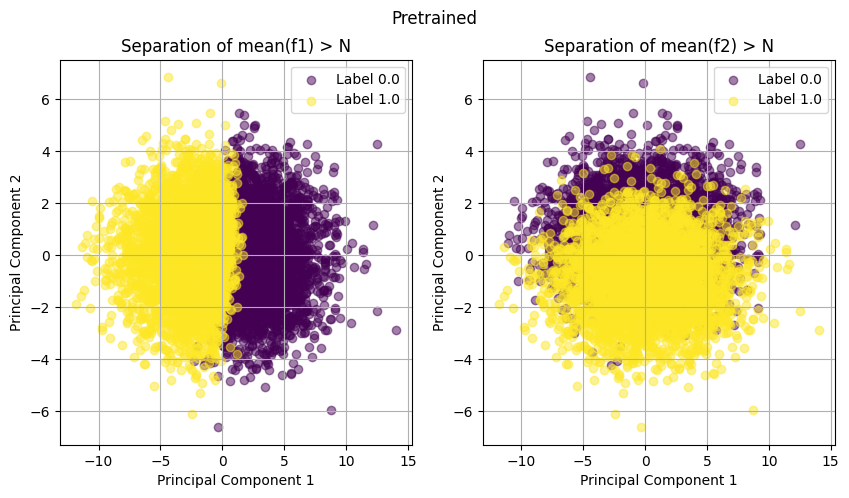

/tmp/ipykernel_1297575/3323052680.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


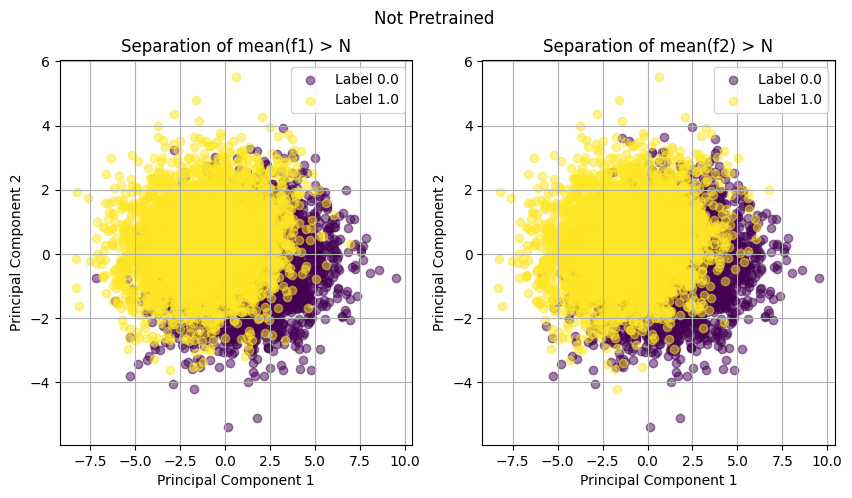

In [26]:
def layer_num_pca(layer_num):
    interm_train_biased, interm_val = eval(f'layer{layer_num}_biased(train_dataset.tensors[0]), layer{layer_num}_biased(val_dataset.tensors[0])')
    plot_pcas(interm_train_biased, labels_train, alt_labels_train, title="Pretrained")

    interm_train_control, interm_val = eval(f'layer{layer_num}_control(train_dataset.tensors[0]), layer{layer_num}_control(val_dataset.tensors[0])')
    plot_pcas(interm_train_control, labels_train, alt_labels_train, title="Not Pretrained")

layer_num_pca(1)

## Covariance Statistics Effect

In [74]:
toy_model_con = ToyModel(6*vec_size, interm_size) ## ab 75-80% baseline
optimizer_con = torch.optim.Adam(toy_model_con.parameters(), lr=0.001)
epochs=6

In [75]:
def task_cov(toy_model, optimizer, epochs, disamb=(0.5, 0.10, 0)):
    train_dataset, val_dataset, _, _ = create_dataset(init_task=False, disamb=disamb, complex=True)
    
    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
    val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
    train_loop(toy_model, train_dataloader, val_dataloader, optimizer, epochs)
    acc, loss = val_loop(toy_model, val_dataloader)
    print(f"ACCURACY: {acc:0.2f}, LOSS: {loss:0.2f}")
task_cov(toy_model_con, optimizer_con, epochs, disamb=(0.5, 0.20, 0))


TypeError: create_dataset() got an unexpected keyword argument 'complex'

In [ ]:
train_dataset, val_dataset, alt_train_dataset, alt_val_dataset = create_dataset(init_task=True, disamb=(0.5, 0.2, 0), complex=True)
label_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
alt_label_dataloader = DataLoader(alt_val_dataset, batch_size=32, shuffle=False)

acc, loss = val_loop(toy_model_cov, label_dataloader)
print(f"F1 LABELS ACCURACY: {acc:0.2f}, LOSS: {loss:0.2f}")

acc, loss = val_loop(toy_model_cov, alt_label_dataloader)
print(f"F2 LABELS ACCURACY: {acc:0.2f}, LOSS: {loss:0.2f}")


In [100]:
toy_model_cov = ToyModel(6*vec_size, interm_size) ## ab 75-80% baseline
optimizer_cov = torch.optim.Adam(toy_model_cov.parameters(), lr=0.001)

In [104]:
task_cov(toy_model_con, optimizer_con, epochs, disamb=(0.5, 0.20, 0))

train_dataset, val_dataset, alt_train_dataset, alt_val_dataset = create_dataset(init_task=False, disamb=(0.5, 0.2, 1), complex=True)
label_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
alt_label_dataloader = DataLoader(alt_val_dataset, batch_size=32, shuffle=False)

acc, loss = val_loop(toy_model_cov, label_dataloader)
print(f"F1 LABELS ACCURACY: {acc:0.2f}, LOSS: {loss:0.2f}")

acc, loss = val_loop(toy_model_cov, alt_label_dataloader)
print(f"F2 LABELS ACCURACY: {acc:0.2f}, LOSS: {loss:0.2f}")

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

ACCURACY: 0.91, LOSS: 0.23


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

F1 LABELS ACCURACY: 0.46, LOSS: 0.79


  0%|          | 0/63 [00:00<?, ?it/s]

F2 LABELS ACCURACY: 0.54, LOSS: 0.72


In [ ]:
layer1_biased = toy_model_cov.fc1
layer2_biased = lambda x: toy_model.fc2(toy_model.relu1(toy_model.fc1(x))) + toy_model.fc1(x)
layer1_control = toy_model_new.fc1
layer2_control = lambda x: toy_model_new.fc2(toy_model_new.relu1(toy_model_new.fc1(x))) + toy_model_new.fc1(x)

train_dataset, val_dataset, alt_train_dataset, alt_val_dataset = create_dataset(init_task=True, disamb=0.5)
labels_train, labels_val = train_dataset.tensors[1], val_dataset.tensors[1]
alt_labels_train, alt_labels_val = alt_train_dataset.tensors[1], alt_val_dataset.tensors[1]

In [ ]:
layer_num_pca(1)

In [24]:
import scipy

scipy.stats.pearsonr(labels_train.squeeze(), alt_labels_train.squeeze()) 
## uncorrelated

PearsonRResult(statistic=-0.0030117006610420635, pvalue=0.7876732749754165)

In [139]:
disamb_learn_numpy.shape

(8000, 128)

In [140]:
labels_train.shape

torch.Size([8000, 1])

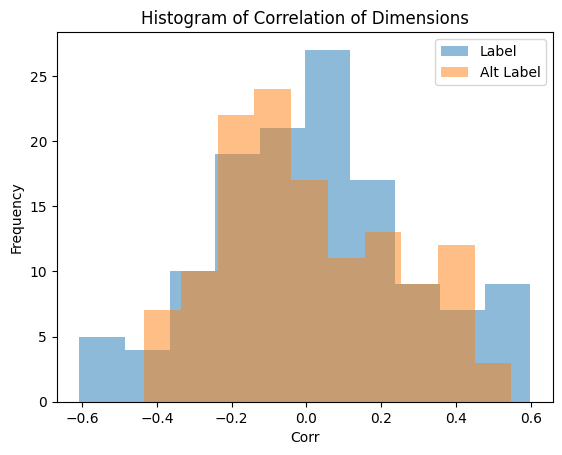

Max Corr Label 0.5988681562903855 , Max Corr Alt Label 0.5482244454480574

Top 10 Corr Label [0.59886816 0.55941821 0.55115218 0.54402599 0.5433952  0.52871933
 0.52069526 0.51768924 0.48808707 0.46045053] 
Top 10 Corr Alt Label [0.54822445 0.47418461 0.46007081 0.43732092 0.42496988 0.41557385
 0.40782031 0.40142805 0.39683998 0.39470528]


In [141]:
corr_label_dims = [scipy.stats.pearsonr(labels_train.squeeze(), interm_train.detach()[:, i]).statistic for i in range(interm_train.shape[1])]
corr_alt_label_dims = [scipy.stats.pearsonr(alt_labels_train.squeeze(), interm_train.detach()[:, i]).statistic for i in range(interm_train.shape[1])]

plt.hist(corr_label_dims, alpha=0.5, label='List 1')
plt.hist(corr_alt_label_dims, alpha=0.5, label='List 2')
plt.title('Histogram of Correlation of Dimensions')
plt.xlabel('Corr')
plt.ylabel('Frequency')
plt.legend(['Label', 'Alt Label'])

plt.show()

print('Max Corr Label', max(corr_label_dims), ', Max Corr Alt Label', max(corr_alt_label_dims))
print('\nTop 10 Corr Label', torch.topk(torch.tensor(corr_label_dims), 10).values.numpy(), '\nTop 10 Corr Alt Label', torch.topk(torch.tensor(corr_alt_label_dims), 10).values.numpy())

Have some higher frequency of correlation, which is important/shows some difference potentially

In [143]:
train_size = int(0.8 * len(interm_train))

train_dataset = TensorDataset(interm_train.detach(), labels_train.view(-1, 1))
val_dataset = TensorDataset(interm_val.detach(), labels_val.view(-1, 1))

train_dataset_alt = TensorDataset(interm_train.detach(), alt_labels_train.view(-1, 1))
val_dataset_alt = TensorDataset(interm_val.detach(), alt_labels_val.view(-1, 1))

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

train_dataloader_alt = DataLoader(train_dataset_alt, batch_size=32, shuffle=True)
val_dataloader_alt = DataLoader(val_dataset_alt, batch_size=32, shuffle=False)

probe_labels = Probe(interm_train.shape[1]).to(device)
probe_alt_labels = Probe(interm_train.shape[1]).to(device)

In [146]:
trainer = Trainer(max_epochs=epochs)
trainer.fit(probe_labels, train_dataloader, val_dataloader)
trainer.validate(probe_labels, val_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type   | Params
--------------------------------
0 | body | Linear | 128   
--------------------------------
128       Trainable params
0         Non-trainable params
128       Total params
0.001     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_acc_epoch       │    0.9664999842643738     │
│      val_loss_epoch       │    0.05521305650472641    │
└───────────────────────────┴───────────────────────────┘

[{'val_loss_epoch': 0.05521305650472641, 'val_acc_epoch': 0.9664999842643738}]

In [147]:
trainer = Trainer(max_epochs=1)
trainer.fit(probe_alt_labels, train_dataloader_alt, val_dataloader_alt)
trainer.validate(probe_alt_labels, val_dataloader_alt)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type   | Params
--------------------------------
0 | body | Linear | 128   
--------------------------------
128       Trainable params
0         Non-trainable params
128       Total params
0.001     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_acc_epoch       │    0.9564999938011169     │
│      val_loss_epoch       │    0.0874154269695282     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss_epoch': 0.0874154269695282, 'val_acc_epoch': 0.9564999938011169}]

## TRANSPLANTATION

In [ ]:
PYTHIA_VOCAB_SIZE = 50277 #50304
N_LAYERS=12
MODEL = "EleutherAI/pythia-160m"
PYTHIA_CHECKPOINTS_OLD = [0, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512] + list(range(1000, 143000 + 1, 10000)) + [143000]
PYTHIA_CHECKPOINTS = [512] + list(range(1000, 10000 + 1, 1000))

HeadName = Literal["previous_token_head", "duplicate_token_head", "induction_head"]
HEAD_NAMES = cast(List[HeadName], get_args(HeadName))

In [ ]:
def create_repeats_dataset(num_samples=50, min_vector_size=5, max_vector_size=50, min_num_repeats=5, max_num_repeats=20, max_vocab=PYTHIA_VOCAB_SIZE):
  """Creates a dataset for the experiment."""
  dataset = []
  for _ in range(num_samples):
    vector_size = torch.randint(min_vector_size, max_vector_size, (1,)).item()
    num_repeats = torch.randint(min_num_repeats, max_num_repeats, (1,)).item()
    tokens = torch.randint(0, max_vocab, (1, vector_size))
    tokens = tokens.repeat((1, num_repeats))
    dataset.append(tokens)
  return dataset

In [ ]:
dataset = torch.load('../outputs/aheads/dataset.pt')

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
def copy_attention_head(model1, model2, layer_idx, head_idx, dataset):
  if model1.isinstance(HookedTransformer) and model2.isinstance(HookedTransformer):
    model1.W_K.data[layer_idx, head_idx, :, :] = model2.W_K.data[layer_idx, head_idx, :, :]
    model1.W_Q.data[layer_idx, head_idx, :, :] = model2.W_Q.data[layer_idx, head_idx, :, :]
    model1.W_V.data[layer_idx, head_idx, :, :] = model2.W_V.data[layer_idx, head_idx, :, :]
    model1.b_K.data[layer_idx, head_idx, :] = model2.b_K.data[layer_idx, head_idx, :]
    model1.b_Q.data[layer_idx, head_idx, :] = model2.b_Q.data[layer_idx, head_idx, :]
    model1.b_V.data[layer_idx, head_idx, :] = model2.b_V.data[layer_idx, head_idx, :]
  else:
    model1.encoder.layers[layer_idx].self_attn.in_proj_weight.data[head_idx,:,:] = model2.encoder.layers[layer_idx].self_attn.in_proj_weight.data[head_idx,:,:]
  return perplexity(model1, dataset), perplexity(model2, dataset)


In [13]:
def calculate_perplexity(corpus, model, device="cpu"):
    encoded_input = model.to_tokens(corpus)
    encoded_input = encoded_input.to(device)
    with torch.no_grad():
      outputs = model(encoded_input).squeeze(0)
      loss = F.cross_entropy(outputs, encoded_input.squeeze(0), reduction='sum')/encoded_input.shape[1]
    perplexity = torch.exp(loss).item()
    return perplexity

In [15]:
def perplexity(model, dataset):
  data_loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=False)
  with torch.no_grad():
    for batch in data_loader:
      inputs, targets = batch
      outputs = model(inputs)
      loss = F.cross_entropy(outputs, targets, reduction='sum')
      total_loss += loss.item()
    average_loss = total_loss / len(data_loader.dataset)
    return torch.exp(torch.tensor(average_loss))

# Attn Head Figure Gen

In [224]:
import pandas as pd
import seaborn as sns

In [242]:
home = os.environ['LEARNING_DYNAMICS_HOME']

In [290]:
def make_line_graph(folder_path, layer, task, output_file):
    csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
    
    nrows = len(csv_files) // 3 + (len(csv_files) % 3 > 0)
    ncols = 3
    
    plt.figure(figsize=(10, 6))

    outputs = []
    for i, file in enumerate(csv_files):
        df = pd.read_csv(os.path.join(folder_path, file), delimiter='\t').drop('Layer', axis=1)
        df = df[['20', '40', '60', '80', '100', '200', '1000', '1400', '1600',
       '1800', '2000']]
        df.index = df.index[::-1]
        if 'head' in file:
            head = file.split('head_')[-1].split('.csv')[0]
            outputs.append((head, df.loc[layer].tolist()))  
            plt.plot(df.columns,  df.loc[layer].tolist(), label=f'Head {head}')
            
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.title(f'{task} - Attention Layer {layer}')
    plt.xlabel('Timestep')
    plt.ylabel('Accuracy')
    legend = plt.legend(title='Legend', title_fontsize='13', fontsize='10', loc='best')

    legend.get_frame().set_edgecolor('black')
    legend.get_frame().set_linewidth(1.5)
    plt.tight_layout()
    plt.savefig(output_file)
    plt.show()
    return outputs, df.columns

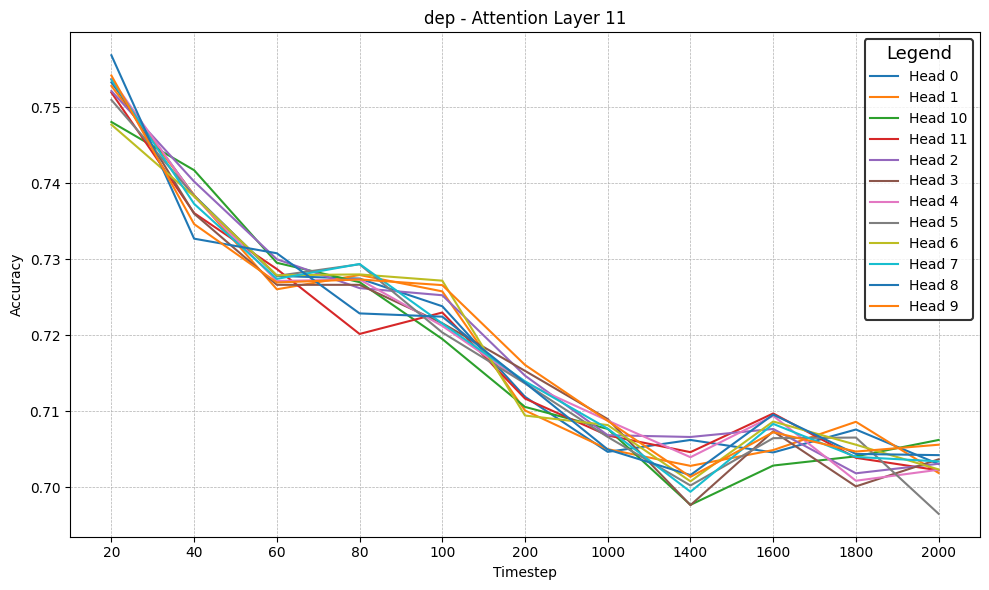

In [291]:

_ = make_line_graph(os.path.join(home, 'outputs/en_ewt-ud/dep/components'), 11, 'dep', os.path.join(home, 'figures/dep_11_heads.png'))

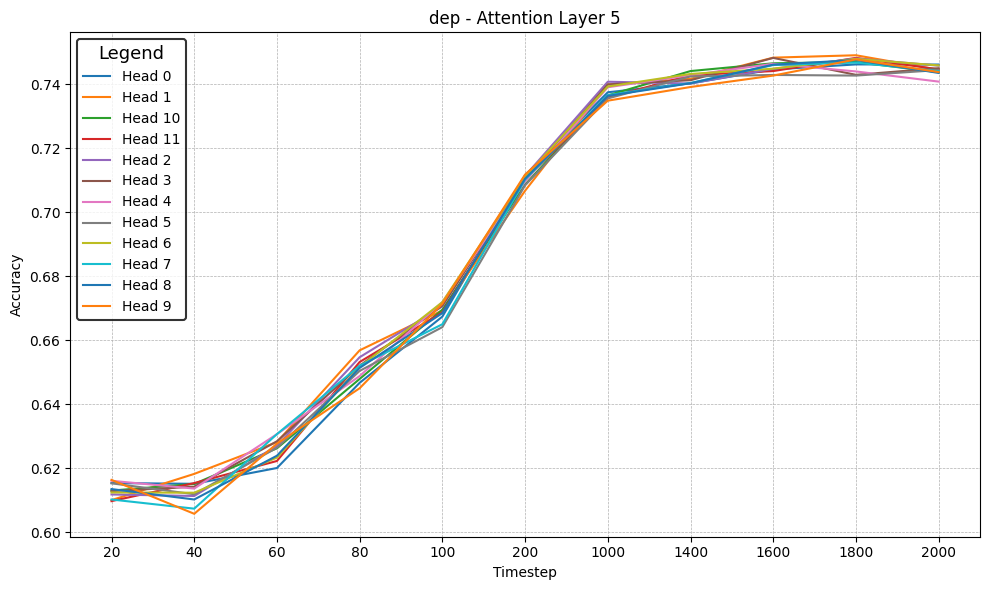

In [292]:
_ = make_line_graph(os.path.join(home, 'outputs/en_ewt-ud/dep/components'), 5, 'dep', os.path.join(home, 'figures/dep_5_heads.png'))

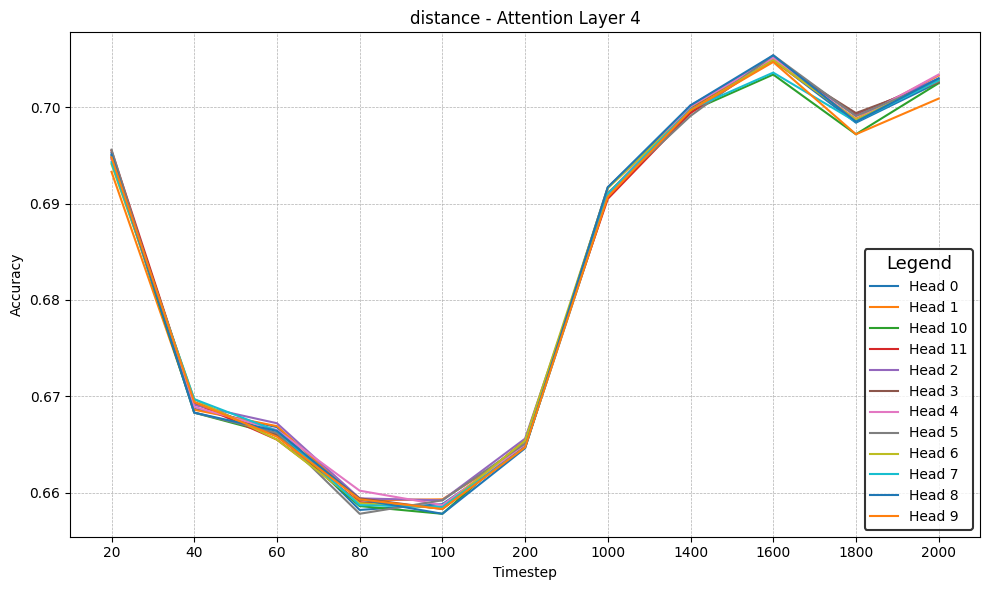

In [310]:
_ = make_line_graph(os.path.join(home, 'outputs/ptb_3/distance/components/DSpr'), 4, 'distance', os.path.join(home, 'figures/head_examples/distance_5_heads.png'))